# How to SOSS, part 1: reading data & tracing
---

**Author: Nestor Espinoza (nespinoza@stsci.edu)**

Let's start by loading some libraries we'll be using:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from scipy.interpolate import splrep, splev

from jwst import datamodels

import transitspectroscopy as ts

## 1. Data reading

Let's read the data. This will read the rates per integration:

In [2]:
datafolder = '/ifs/jwst/wit/witserv/data18/nis_commissioning/nis-034_1541/data/01541/'

In [3]:
tso1 = datamodels.open(datafolder + 'jw01541001001_04101_00001-seg001_nis_rateints.fits')
tso2 = datamodels.open(datafolder + 'jw01541001001_04101_00001-seg002_nis_rateints.fits')
tso3 = datamodels.open(datafolder + 'jw01541001001_04101_00001-seg003_nis_rateints.fits')
tso4 = datamodels.open(datafolder + 'jw01541001001_04101_00001-seg004_nis_rateints.fits')

Data is divided in segments so they are easier to process, but for our application we don't need to have them separated. So we'll join all in single set of arrays: 

In [4]:
# Data:
tso = np.vstack((tso1.data, tso2.data))
tso = np.vstack((tso, tso3.data))
tso = np.vstack((tso, tso4.data))

# Errors:
tso_err = np.vstack((tso1.err, tso2.err))
tso_err = np.vstack((tso_err, tso3.err))
tso_err = np.vstack((tso_err, tso4.err))

To trace the spectra for this set of exercises, we'll do it on the median image (i.e., combine all the frames from all the integrations) to have a very high signal-to-noise frame to work on:

In [5]:
median_tso = np.median(tso, axis = 0) 

## 2. Let's trace!

Let's trace the spectra for Orders 1, 2 and 3. To do this, we need to define some parameters for the cross-correlation we will do:

In [6]:
ccf_parameters = [-7.5, 3.0, 7.5, 3.0]

And now we need to define some starting points for the tracing algorithm. To this end we cross correlate one of the columns, and use that as our starting points. Let's plot the median frame first to identify these starting points by eye (they should be similar for different datasets):

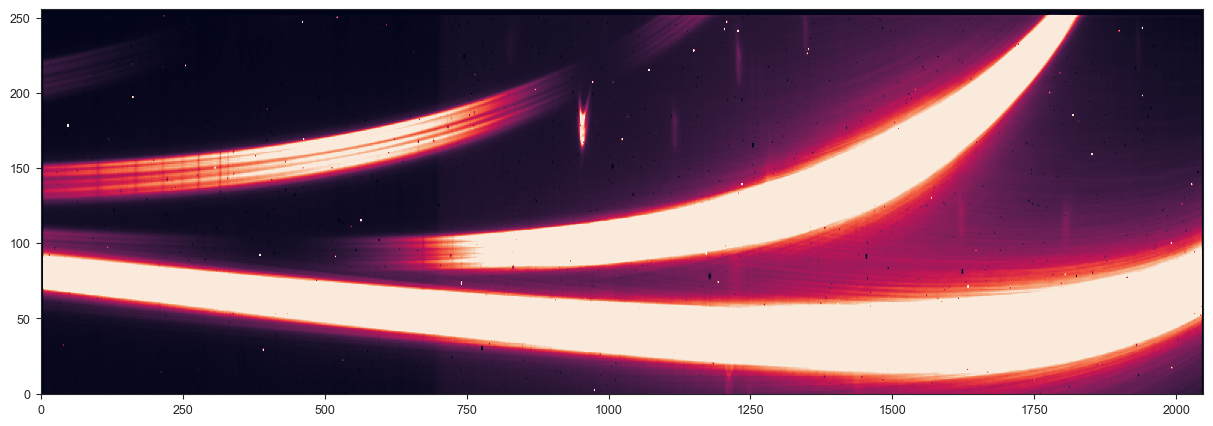

In [8]:
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, origin = 'lower', aspect = 'auto')

im.set_clim(2,30)

Now let's cross-correlate gaussians against some columns based on that. For instance, we cross-correlate Order 1 on the very right-most column, Order 2 around column 1750 (which is where it more or less Order 2 starts) and order 3 at around column 900:

In [9]:
lags1, ccf1 = ts.spectroscopy.get_ccf(np.arange(median_tso.shape[0]), median_tso[:, 2043], 
                                         function = 'double gaussian', parameters = ccf_parameters)

lags2, ccf2 = ts.spectroscopy.get_ccf(np.arange(median_tso.shape[0]), median_tso[:, 1750], 
                                         function = 'double gaussian', parameters = ccf_parameters)

lags3, ccf3 = ts.spectroscopy.get_ccf(np.arange(median_tso.shape[0]), median_tso[:, 900], 
                                         function = 'double gaussian', parameters = ccf_parameters)

Let's plot and define the starting points from these CCFs:

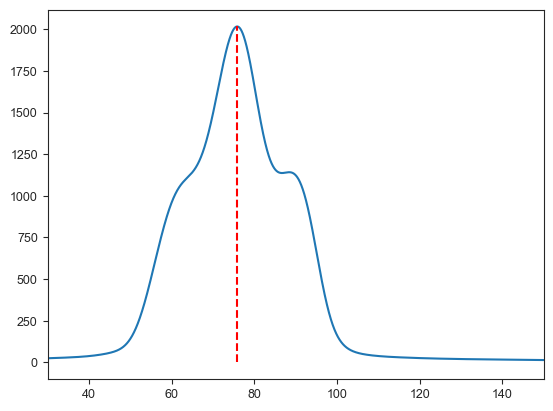

In [10]:
plt.plot(lags1, ccf1)
plt.xlim(30,150)

idx = np.where(np.max(ccf1) == ccf1)[0]
ystart1 = lags1[idx][0]
plt.plot([ystart1, ystart1], [0, np.max(ccf1)], 'r--')

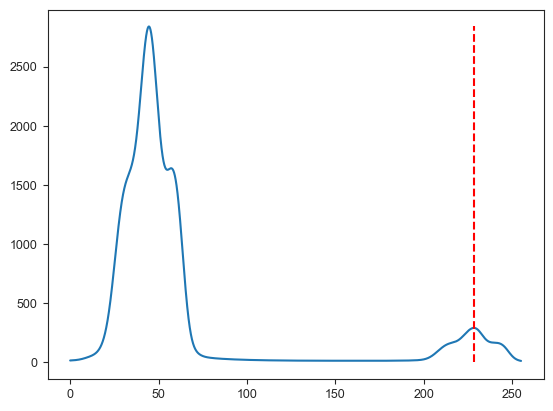

In [12]:
plt.plot(lags2, ccf2)

idx_large = np.where(lags2>200)[0]
ccf2 = np.array(ccf2)

idx = np.where( np.max(ccf2[idx_large]) == ccf2[idx_large] )[0]

ystart2 = lags2[idx_large][idx][0]
plt.plot([ystart2, ystart2], [0, np.max(ccf2)], 'r--')

(0.0, 100.0)

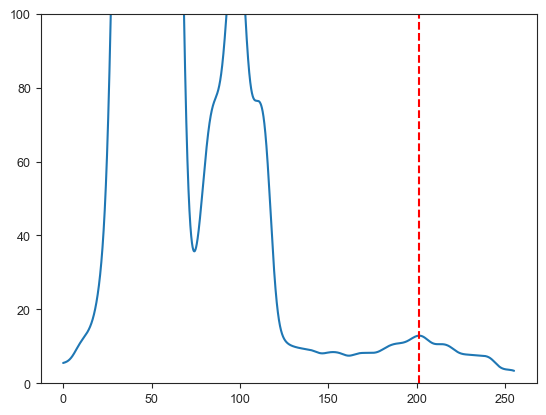

In [14]:
plt.plot(lags3, ccf3)

idx_large = np.where(lags3>150)[0]
ccf3 = np.array(ccf3)

idx = np.where( np.max(ccf3[idx_large]) == ccf3[idx_large] )[0]

ystart3 = lags3[idx_large][idx][0]
plt.plot([ystart3, ystart3], [0, np.max(ccf3)], 'r--')
plt.ylim(0,100)

Let's trace. Order 1 first:

In [15]:
x1, y1 = ts.spectroscopy.trace_spectrum(median_tso, np.zeros(median_tso.shape), 
                                           xstart = 2043, ystart = ystart1, xend = 4, 
                                           ccf_function = 'double gaussian', 
                                           ccf_parameters = ccf_parameters)

Now Order 2:

In [16]:
x2_end, x2_start = 600, 1750

x2, y2 = ts.spectroscopy.trace_spectrum(median_tso, np.zeros(median_tso.shape), 
                                           xstart = x2_start, ystart = ystart2, xend = x2_end, 
                                           ccf_function = 'double gaussian', 
                                           ccf_parameters = ccf_parameters, 
                                           y_tolerance = 4)

And Order 3:

In [17]:
x3_end, x3_start = 4, 900

x3, y3 = ts.spectroscopy.trace_spectrum(median_tso, np.zeros(median_tso.shape), 
                                           xstart = x3_start, ystart = ystart3, xend = x3_end, 
                                           ccf_function = 'double gaussian', 
                                           ccf_parameters = ccf_parameters, 
                                           y_tolerance = 4)

Let's see how we did:

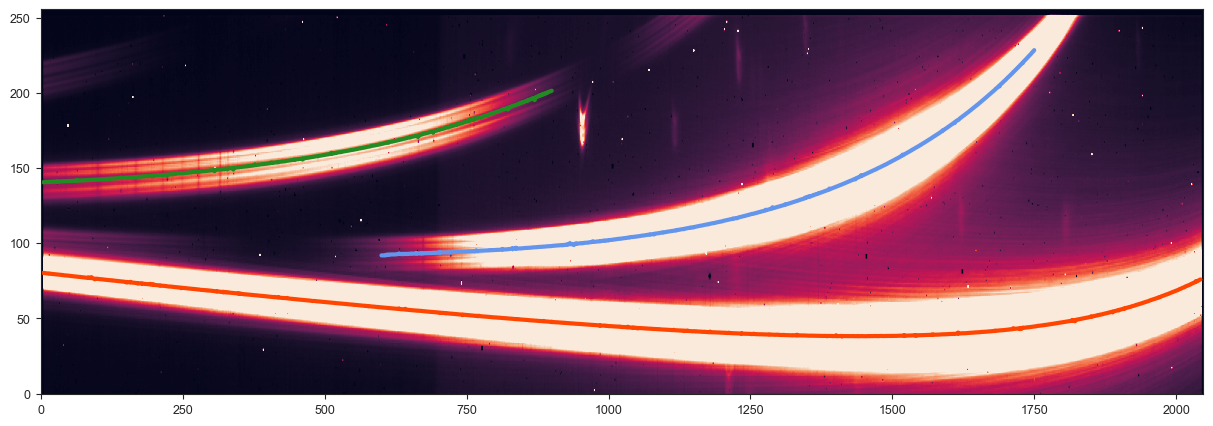

In [18]:
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, origin = 'lower', aspect = 'auto')

plt.plot(x1, y1, color = 'orangered', lw = 3)
plt.plot(x2, y2, color = 'cornflowerblue', lw = 3)
plt.plot(x3, y3, color = 'forestgreen', lw = 3)

im.set_clim(2,30)

That looks pretty good! We can also smooth those traces via splines (polynomials are not very good at this level of precision --- traces are just _too good!_):

In [19]:
x_knots1 = [[6, 1200-5], [1200, 1500-5], [1500, 1700-5],[1700, 2041]]
nknots1 = [4,2,3,4]

x_knots2 = [[601, 850-5], [850, 1100-5],[1100,1749]]
nknots2 = [2, 2, 5]

In [20]:
_, sfit1 = ts.utils.fit_spline(x1, y1, nknots = nknots1, x_knots = x_knots1)
_, sfit2 = ts.utils.fit_spline(x2, y2, nknots = nknots2, x_knots = x_knots2)
_, sfit3 = ts.utils.fit_spline(x3, y3, nknots = 10)

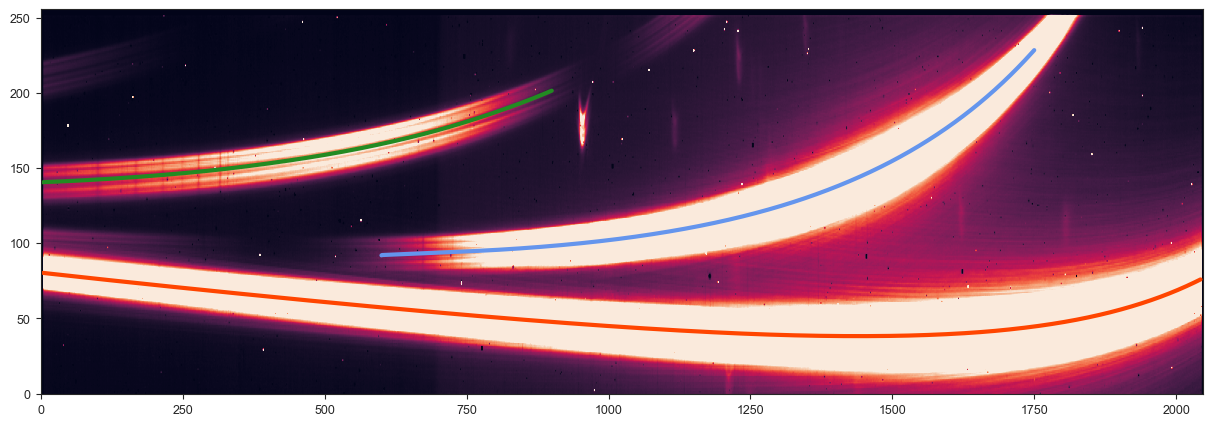

In [21]:
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, origin = 'lower', aspect = 'auto')

plt.plot(x1, sfit1, color = 'orangered', lw = 3)
plt.plot(x2, sfit2, color = 'cornflowerblue', lw = 3)
plt.plot(x3, sfit3, color = 'forestgreen', lw = 3)

im.set_clim(2,30)

## 3. Getting pupil wheel & filter positions

So, how do we extract pupil and filter wheel positions? The `datamodels` make this very easy! We can ask directly where those are:

In [23]:
tso1.search('pupil')

root (AsdfObject)
└─meta (dict)
  └─instrument (dict)
    ├─pupil (str): GR700XD
    └─pupil_position (float): 245.8984379999796

In [24]:
tso1.search('filter')

root (AsdfObject)
└─meta (dict)
  └─instrument (dict)
    ├─filter (str): CLEAR
    └─filter_position (float): 74.87733460000561

If you want the numbers directly, you can use the tree of keys given up:

In [25]:
tso1.meta.instrument.pupil_position

245.8984379999796

In [26]:
tso1.meta.instrument.filter_position

74.87733460000561

And that's it!